# CNN model using k-mer embeddings learned from human genome
- Train Dataset = Human + Worm
- Test Dataset = Human, Worm


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from Bio.SeqIO.FastaIO import SimpleFastaParser
from sklearn.utils import resample
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize, MaxAbsScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier


In [2]:
input_hot_human = '../data/hot_lot_seqs/human/hot_regions_01_all.fa'
input_lot_human = '../data/hot_lot_seqs/human/lot_regions_01_all.fa'
input_hot_worm = '../data/hot_lot_seqs/worm/hot_region_01_all.fa'
input_lot_worm = '../data/hot_lot_seqs/worm/lot_region_01_all.fa'
kmer_length = 4
sampling_percentage = 1
seed = 35

In [3]:
with open(input_hot_human) as fasta_file:
    hot_sequences_human = []
    for title, sequence in SimpleFastaParser(fasta_file):
        if "N" not in sequence:
            hot_sequences_human.append(sequence)

with open(input_lot_human) as fasta_file:
    lot_sequences_human = []
    for title, sequence in SimpleFastaParser(fasta_file):
        if "N" not in sequence:
            lot_sequences_human.append(sequence)

with open(input_hot_worm) as fasta_file:
    hot_sequences_worm = []
    for title, sequence in SimpleFastaParser(fasta_file):
        if "N" not in sequence:
            hot_sequences_worm.append(sequence)

with open(input_lot_worm) as fasta_file:
    lot_sequences_worm = []
    for title, sequence in SimpleFastaParser(fasta_file):
        if "N" not in sequence:
            lot_sequences_worm.append(sequence)

### Create dataset for human and worm with two class label
The following cell creates dataframes for the HOT and LOT sequences with the following labels:
- *1* for HOT sequences (positive class)
- *0* for LOT sequences (negative class)

In [4]:
df_hot = pd.DataFrame(hot_sequences_human, columns=['sequence'])
df_hot['label'] = 1

df_lot = pd.DataFrame(lot_sequences_human, columns=['sequence'])
df_lot['label'] = 0

human_data = pd.concat([df_hot, df_lot])
human_data.label.value_counts()

1    1504
0    1495
Name: label, dtype: int64

In [5]:
df_hot = pd.DataFrame(hot_sequences_worm, columns=['sequence'])
df_hot['label'] = 1

df_lot = pd.DataFrame(lot_sequences_worm, columns=['sequence'])
df_lot['label'] = 0

worm_data = pd.concat([df_hot, df_lot])
worm_data.label.value_counts()

1    20139
0    18792
Name: label, dtype: int64

In [6]:
def seq2kmer_dataset(data, k, scaled= True):
    k = 4
    seq_kmers = []
    for df in range(len(data)):
        seq = data.iloc[df]['sequence']
        kmers = [seq[i:i+k].upper() for i in range(len(seq)-k+1)]
        kmers = ' '.join(kmers)
        seq_kmers.append(kmers)

    labels = data.loc[:,:]['label'].values

    c = CountVectorizer(ngram_range=(1,1))
    x = c.fit_transform(seq_kmers)
    scaler = MaxAbsScaler()
    x_scaled = scaler.fit_transform(normalize(x))
    df_kmer = pd.DataFrame(x.toarray(), columns=c.vocabulary_)
    df_kmer = df_kmer.reindex(sorted(df_kmer.columns), axis=1)

    df_kmer_scaled = pd.DataFrame(x_scaled.toarray(), columns=c.vocabulary_)
    df_kmer_scaled = df_kmer_scaled.reindex(sorted(df_kmer_scaled.columns), axis=1)

    if scaled:
        return df_kmer_scaled, labels
    else:
        return df_kmer, labels


In [28]:
### Load the embedding vectors for k-mers from the file
import csv
reader = csv.reader(open('../data/pretrained/dna2vec-20161219-0153-k3to8-100d-10c-29320Mbp-sliding-Xat.csv', 'r')) 
kmers_wv = {}
for row in reader:
    k = row[0]
    kmers_wv[k] = row[1:]


def count2embeddings(kmers_dict, X):
    wvs = []
    for kmer in X.columns:
        wvs.append(kmers_dict[kmer.upper()])
    wvs = np.array(wvs, dtype=float)
    
    X_vec = []
    for i in range(X.shape[0]):
        m2 = np.stack((X.iloc[i,:],) * wvs.shape[1], axis=1)
        vec_X = np.multiply(m2, wvs)
        X_vec.append(vec_X)
    X_vec = np.array(X_vec)
    return X_vec 



In [ ]:
Xh, yh = seq2kmer_dataset(human_data, 4, scaled=True)
Xw, yw = seq2kmer_dataset(worm_data, 4, scaled=True)

Xh = count2embeddings(kmers_wv, Xh)
Xw = count2embeddings(kmers_wv, Xw)

X_trainh, X_testh, Y_trainh, Y_testh = train_test_split(Xh, yh, test_size = 0.25, random_state=seed, stratify=yh)
X_trainw, X_testw, Y_trainw, Y_testw = train_test_split(Xw, yw, test_size = 0.25, random_state=seed, stratify=yw)

X_train_ = np.concatenate((X_trainh, X_trainw), axis=0)
y_train_ = np.concatenate((Y_trainh, Y_trainw), axis=0)

In [34]:
X_train_.shape

(31447, 256, 100)

In [35]:
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

2022-12-08 16:21:12.989806: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [36]:
inputs = keras.Input(shape= X_train_.shape[1:], name="Input Sequence")

x_a = layers.Conv1D(filters = 120, kernel_size = 1, activation='relu')(inputs)
x_b = layers.Conv1D(filters = 120, kernel_size = 3, activation='relu')(inputs)
x_c = layers.Conv1D(filters = 120, kernel_size = 5, activation='relu')(inputs)
x_d = layers.Conv1D(filters = 120, kernel_size = 9, activation='relu')(inputs)
#x_e = layers.Conv1D(filters = 120, kernel_size = 15, activation='relu')(inputs)
#x_f = layers.Conv1D(filters = 120, kernel_size = 20, activation='relu')(inputs)

x_1 = layers.Concatenate(axis=1)([x_a, x_b, x_c, x_d])

x = layers.Flatten()(x_1)
#x = layers.Dense(512, activation="relu")(x)
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs, name="hot_model")

2022-12-08 16:21:37.147226: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [37]:
model.summary()

Model: "hot_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input Sequence (InputLayer)    [(None, 256, 100)]   0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 256, 120)     12120       ['Input Sequence[0][0]']         
                                                                                                  
 conv1d_1 (Conv1D)              (None, 254, 120)     36120       ['Input Sequence[0][0]']         
                                                                                                  
 conv1d_2 (Conv1D)              (None, 252, 120)     60120       ['Input Sequence[0][0]']         
                                                                                          

In [39]:

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(),
                       tf.keras.metrics.FalsePositives(),
                       tf.keras.metrics.FalseNegatives()])

checkpoint = keras.callbacks.ModelCheckpoint(filepath='saved_models/both/my_best_model.epoch{epoch:02d}-acc{val_binary_accuracy:.2f}.hdf5', 
                             monitor='val_binary_accuracy',
                             verbose=1, 
                             save_best_only=True,
                             mode='max')


In [40]:
history = model.fit(
    x=X_train_,
    y=y_train_,
    batch_size=32,
    epochs=50,
    verbose='auto',
    callbacks=[checkpoint],
    validation_split=0.20,
    validation_data=None,
    shuffle=True,
    class_weight=None,
    sample_weight=None,
    initial_epoch=0,
    steps_per_epoch=None,
    validation_steps=None,
    validation_batch_size=None,
    validation_freq=1,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=False
)

Epoch 1/50
787/787 [==============================] - ETA: 0s - loss: 0.4771 - binary_accuracy: 0.7892 - false_positives_1: 2929.0000 - false_negatives_1: 2374.0000
Epoch 1: val_binary_accuracy improved from -inf to 0.80763, saving model to saved_models/both/my_best_model.epoch01-acc0.81.hdf5
787/787 [==============================] - 94s 117ms/step - loss: 0.4771 - binary_accuracy: 0.7892 - false_positives_1: 2929.0000 - false_negatives_1: 2374.0000 - val_loss: 0.4243 - val_binary_accuracy: 0.8076 - val_false_positives_1: 877.0000 - val_false_negatives_1: 333.0000
Epoch 2/50
787/787 [==============================] - ETA: 0s - loss: 0.3926 - binary_accuracy: 0.8276 - false_positives_1: 2491.0000 - false_negatives_1: 1846.0000
Epoch 2: val_binary_accuracy improved from 0.80763 to 0.82226, saving model to saved_models/both/my_best_model.epoch02-acc0.82.hdf5
787/787 [==============================] - 94s 119ms/step - loss: 0.3926 - binary_accuracy: 0.8276 - false_positives_1: 2491.0000 -

## Performance on Human Test set

24/24 [==============================] - 1s 22ms/step
Accuracy for Human = 0.8946666666666667
              precision    recall  f1-score   support

           0       0.86      0.94      0.90       374
           1       0.94      0.85      0.89       376

    accuracy                           0.89       750
   macro avg       0.90      0.89      0.89       750
weighted avg       0.90      0.89      0.89       750



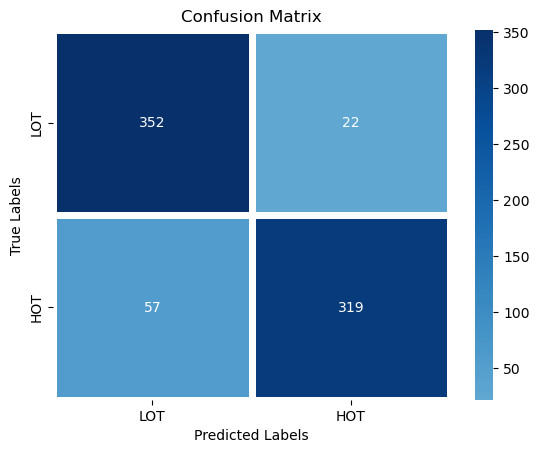

In [41]:
prob = model.predict(X_testh)
y_pred = np.array([1 if p>0.5 else 0 for p in prob])

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
print('Accuracy for Human =', accuracy_score(Y_testh, y_pred))
print(classification_report(Y_testh, y_pred))
cf = confusion_matrix(Y_testh, y_pred)
ax = plt.subplot()
sns.heatmap(cf, annot=True, fmt='d', ax=ax, linewidths=5, cmap="Blues", center=0)
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['LOT', 'HOT'])
ax.yaxis.set_ticklabels(['LOT', 'HOT'])
plt.show()

In [42]:
list(history.history.keys())

['loss',
 'binary_accuracy',
 'false_positives_1',
 'false_negatives_1',
 'val_loss',
 'val_binary_accuracy',
 'val_false_positives_1',
 'val_false_negatives_1']

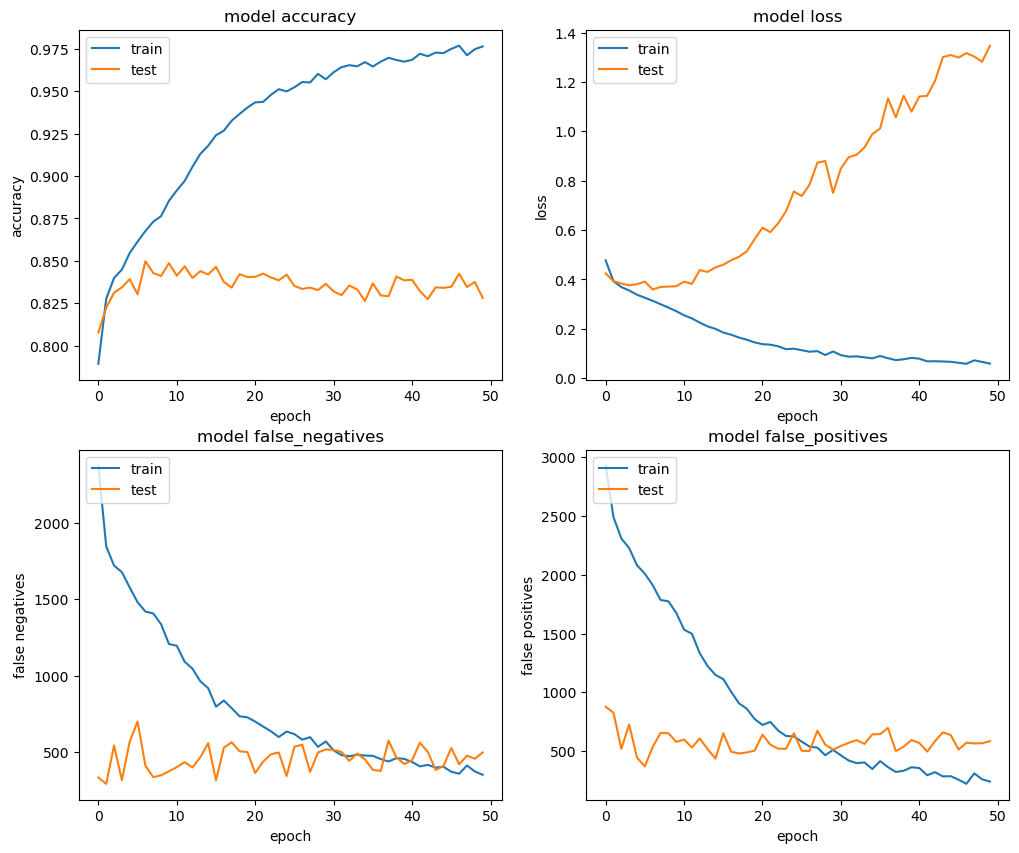

In [43]:
metrics = list(history.history.keys())
fig = plt.figure(figsize=(12,10))
# summarize history for accuracy
plt.subplot(2,2,1)
plt.plot(history.history[metrics[1]])
plt.plot(history.history[metrics[5]])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
#plt.show()
# summarize history for loss
plt.subplot(2,2,2)
plt.plot(history.history[metrics[0]])
plt.plot(history.history[metrics[4]])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
#plt.show()
# summarize history for false_negatives
plt.subplot(2,2,3)
plt.plot(history.history[metrics[3]])
plt.plot(history.history[metrics[7]])
plt.title('model false_negatives')
plt.ylabel('false negatives')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
#plt.show()

# summarize history for false_positives
plt.subplot(2,2,4)
plt.plot(history.history[metrics[2]])
plt.plot(history.history[metrics[6]])
plt.title('model false_positives')
plt.ylabel('false positives')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Performance on Worm Test set

305/305 [==============================] - 6s 20ms/step
Accuracy for Worm = 0.8263639165724853
              precision    recall  f1-score   support

           0       0.83      0.81      0.82      4698
           1       0.82      0.84      0.83      5035

    accuracy                           0.83      9733
   macro avg       0.83      0.83      0.83      9733
weighted avg       0.83      0.83      0.83      9733



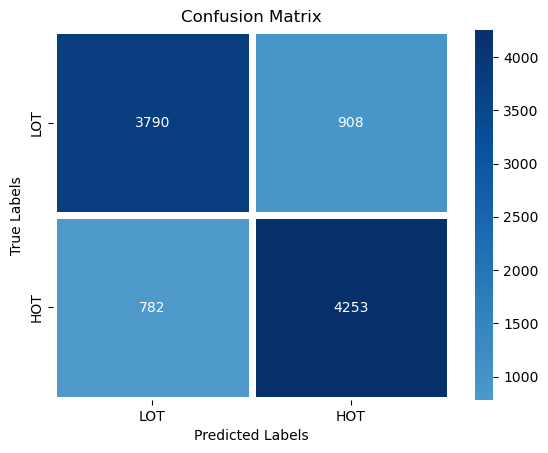

In [44]:
prob = model.predict(X_testw)
y_pred = np.array([1 if p>0.5 else 0 for p in prob])

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
print('Accuracy for Worm =', accuracy_score(Y_testw, y_pred))
print(classification_report(Y_testw, y_pred))
cf = confusion_matrix(Y_testw, y_pred)
ax = plt.subplot()
sns.heatmap(cf, annot=True, fmt='d', ax=ax, linewidths=5, cmap="Blues", center=0)
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['LOT', 'HOT'])
ax.yaxis.set_ticklabels(['LOT', 'HOT'])
plt.show()

In [45]:
list(history.history.keys())

['loss',
 'binary_accuracy',
 'false_positives_1',
 'false_negatives_1',
 'val_loss',
 'val_binary_accuracy',
 'val_false_positives_1',
 'val_false_negatives_1']

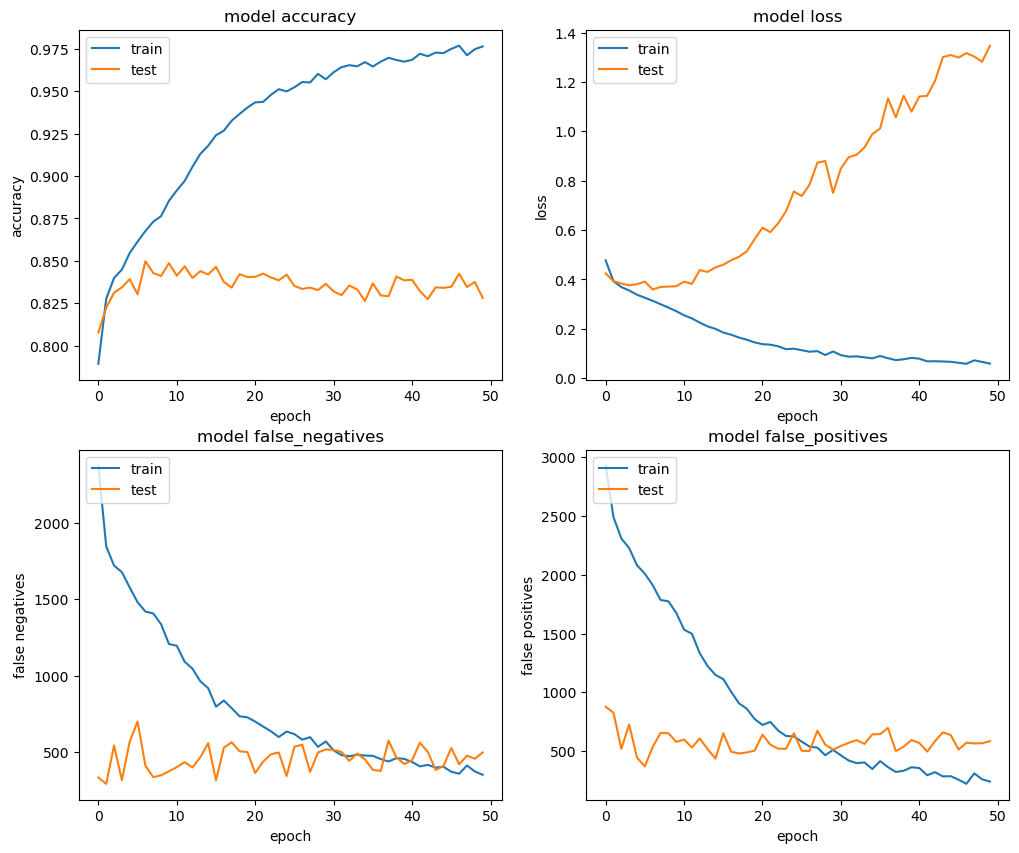

In [46]:
metrics = list(history.history.keys())
fig = plt.figure(figsize=(12,10))
# summarize history for accuracy
plt.subplot(2,2,1)
plt.plot(history.history[metrics[1]])
plt.plot(history.history[metrics[5]])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
#plt.show()
# summarize history for loss
plt.subplot(2,2,2)
plt.plot(history.history[metrics[0]])
plt.plot(history.history[metrics[4]])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
#plt.show()
# summarize history for false_negatives
plt.subplot(2,2,3)
plt.plot(history.history[metrics[3]])
plt.plot(history.history[metrics[7]])
plt.title('model false_negatives')
plt.ylabel('false negatives')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
#plt.show()

# summarize history for false_positives
plt.subplot(2,2,4)
plt.plot(history.history[metrics[2]])
plt.plot(history.history[metrics[6]])
plt.title('model false_positives')
plt.ylabel('false positives')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()